<a href="https://colab.research.google.com/github/efsiul/fruit_sorter_project/blob/master/Luis_Cadavid_Johana_Rios_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install tensorflow

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

In [ ]:
# Cargar el modelo base de ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


In [ ]:
# Crear entradas con la forma correcta
inputs = Input(shape=(224, 224, 3))

# Pasar las entradas a través del modelo base
x = base_model(inputs, training=False)

# Añadir una capa de pooling global
x = layers.GlobalAveragePooling2D()(x)

# Añadir la capa densa final
outputs = layers.Dense(6, activation='softmax')(x)


In [ ]:
# Combinar entradas y salidas para crear el modelo
model = models.Model(inputs, outputs)

# Mostrar el resumen del modelo
model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 6)                 12294     
                                                                 
Total params: 23600006 (90.03 MB)
Trainable params: 12294 (48.02 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
# Compilar el modelo
model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
# Configurar los generadores de datos
datagen_train = ImageDataGenerator(samplewise_center=True,  # normalizar
    rotation_range=10,  # rotar aleatoriamente
    zoom_range=0.1,  # hacer zoom aleatoriamente
    width_shift_range=0.1,  # desplazar horizontalmente
    height_shift_range=0.1,  # desplazar verticalmente
    horizontal_flip=True,  # voltear horizontalmente
    vertical_flip=True)  # voltear verticalmente

datagen_valid = ImageDataGenerator(samplewise_center=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cargar y iterar sobre el conjunto de datos de entrenamiento
train_it = datagen_train.flow_from_directory(
    '/content/drive/MyDrive/Udea/Simulación/train',
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
)

# Cargar y iterar sobre el conjunto de datos de validación
valid_it = datagen_valid.flow_from_directory(
    '/content/drive/MyDrive/Udea/Simulación/test',
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    shuffle=False  # Asegurar que el orden de las imágenes sea el mismo para predicciones y etiquetas
)

Found 9833 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


In [ ]:
# Entrenar el modelo
model.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=train_it.samples /train_it.batch_size,
          validation_steps=valid_it.samples /valid_it.batch_size,
          epochs=20)

Epoch 1/20
307/307 [==============================] - 287s 925ms/step - loss: 0.2608 - categorical_accuracy: 0.9126 - val_loss: 0.0797 - val_categorical_accuracy: 0.9741
Epoch 2/20
307/307 [==============================] - 275s 894ms/step - loss: 0.0766 - categorical_accuracy: 0.9749 - val_loss: 0.0566 - val_categorical_accuracy: 0.9833
Epoch 3/20
307/307 [==============================] - 274s 890ms/step - loss: 0.0501 - categorical_accuracy: 0.9837 - val_loss: 0.0429 - val_categorical_accuracy: 0.9870
Epoch 4/20
307/307 [==============================] - 273s 889ms/step - loss: 0.0390 - categorical_accuracy: 0.9871 - val_loss: 0.0356 - val_categorical_accuracy: 0.9826
Epoch 5/20
307/307 [==============================] - 273s 889ms/step - loss: 0.0316 - categorical_accuracy: 0.9895 - val_loss: 0.0329 - val_categorical_accuracy: 0.9907
Epoch 6/20
307/307 [==============================] - 276s 896ms/step - loss: 0.0270 - categorical_accuracy: 0.9914 - val_loss: 0.0230 - val_categoric

In [ ]:
# Evaluar el modelo
model.evaluate(valid_it, steps=valid_it.samples /valid_it.batch_size)

84/84 [==============================] - 47s 556ms/step - loss: 0.0196 - categorical_accuracy: 0.9926


[0.01956038549542427, 0.9925870895385742]

In [ ]:
# Generar predicciones
valid_it.reset()  # Reiniciar el generador antes de predecir
y_pred = model.predict(valid_it, steps=valid_it.samples /valid_it.batch_size + 1, verbose=1)
y_true = valid_it.classes

85/85 [============================>.] - ETA: 0s

85/85 [==============================] - 48s 549ms/step


In [ ]:
# Asegurarse de que y_pred cubra todas las muestras
if y_pred.shape[0] > y_true.shape[0]:
    y_pred = y_pred[:y_true.shape[0]]
elif y_pred.shape[0] < y_true.shape[0]:
    y_true = y_true[:y_pred.shape[0]]

In [ ]:
# Convertir las predicciones de probabilidades a etiquetas de clase
y_pred_classes = np.argmax(y_pred, axis=1)

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)

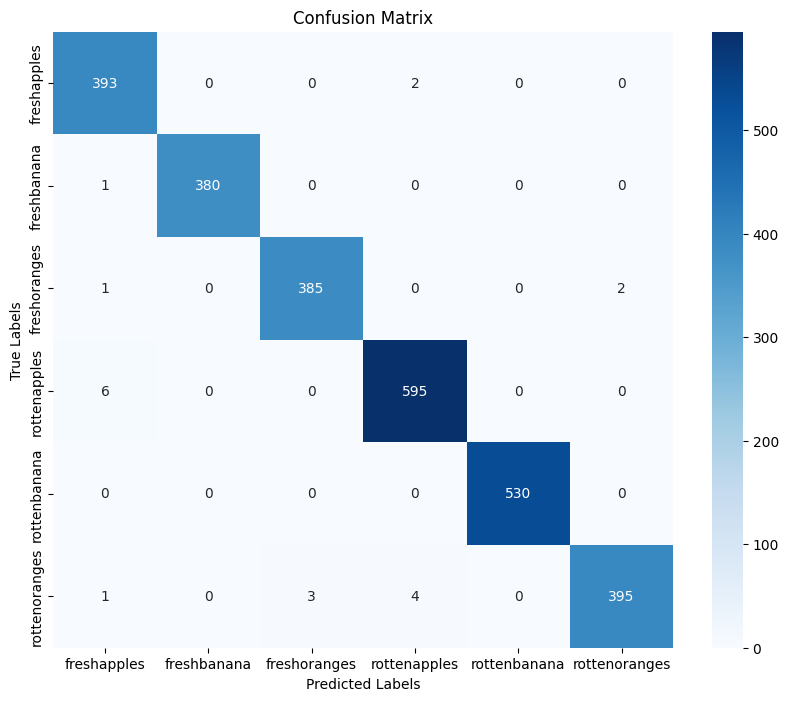

In [ ]:
# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=valid_it.class_indices.keys(), yticklabels=valid_it.class_indices.keys())
plt.title('ResNet50 Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# Calcular e imprimir el informe de clasificación
class_report = classification_report(y_true, y_pred_classes, target_names=valid_it.class_indices.keys())
print("ResNet50 Classification Report:")
print(class_report)

Classification Report:
               precision    recall  f1-score   support

  freshapples       0.98      0.99      0.99       395
  freshbanana       1.00      1.00      1.00       381
 freshoranges       0.99      0.99      0.99       388
 rottenapples       0.99      0.99      0.99       601
 rottenbanana       1.00      1.00      1.00       530
rottenoranges       0.99      0.98      0.99       403

     accuracy                           0.99      2698
    macro avg       0.99      0.99      0.99      2698
 weighted avg       0.99      0.99      0.99      2698



In [ ]:
import pickle
from google.colab import files

# Guarda el modelo entrenado en un archivo .pkl
with open('modelo_entrenado.pkl', 'wb') as f:
    pickle.dump(model, f)

# Descarga el archivo .pkl desde Google Colab
files.download('modelo_entrenado.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
%pip freeze

absl-py==1.4.0
altair==4.2.2
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
astunparse==1.6.3
attrs==23.2.0
audioread==3.0.1
backcall==0.2.0
beautifulsoup4==4.12.3
bleach==6.1.0
blinker==1.4
blis==0.7.11
build==1.2.1
cachetools==5.3.3
catalogue==2.0.10
certifi==2024.2.2
cffi==1.16.0
charset-normalizer==3.3.2
chex==0.1.86
click==8.1.7
cloud-tpu-client==0.10
cloudpathlib==0.16.0
cloudpickle==3.0.0
confection==0.1.4
contourpy==1.2.1
cryptography==3.4.8
cycler==0.12.1
cymem==2.0.8
dbus-python==1.2.18
debugpy==1.6.6
decorator==5.1.1
defusedxml==0.7.1
distrax==0.1.5
distro==1.7.0
dm-tree==0.1.8
dopamine_rl==4.0.9
en-core-web-sm @ https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl#sha256=86cc141f63942d4b2c5fcee06630fd6f904788d2f0ab005cce45aadb8fb73889
entrypoints==0.4
etils==1.7.0
exceptiongroup==1.2.1
fastai==2.7.15
fastcore==1.5.38
fastdownload==0.0.7
fastjsonschema=